# Hands On Astropy Tutorial - Solutions to the exercises
**Tutors:** Axel Donath and Johannes King


This notebook contains the solutions to the exercises in [astropy_hands_on.ipynb](https://github.com/Asterics2020-Obelics/School2017/blob/master/astropy/astropy_hands_on.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt


## 1. Units and Quantities

- (*easy*) How long does the light travel from the sun to the earth in minutes? How long does the light travel from the Galactic center (assume a distance of 8 kpc) in years? 


In [2]:
from astropy import constants as const
import astropy.units as u

# distance sun - earth
distance_sun = 1 * u.au
# speed of light
speed = const.c
# time
time_sun = distance_sun / speed
print("Light travels from sun to earth in {:.2f}".format(time_sun.to('min')))

# distance to GC
distance_gc = 8 * u.kpc
# time
time_gc = distance_gc / speed
print("Light travels from the GC to earth in {:.2f}".format(time_gc.to('yr')))

Light travels from sun to earth in 8.32 min
Light travels from the GC to earth in 26092.51 yr


- (*advanced*) Define a new unit called `"baro-meter"`, which is eqivalent to 25 cm and use it to measure the height of the empire state building (assume a height of 381 meters). Please read the [Astropy documentation on equivalencies](http://docs.astropy.org/en/stable/units/equivalencies.html#writing-new-equivalencies) for an example how to do this ( For other ways to measure the height of a building using a barometer see [barometer question on Wikipedia](https://en.wikipedia.org/wiki/Barometer_question)...)

In [3]:
# define new unit baro-meter
bm = u.def_unit('baro-meter')

# define equivalency
baro_meter = [
   (bm, u.cm, lambda x: 25 * x, lambda x: x / 25)
]

# height of the empire state building
height = 381 * u.m

# convert to baro-meters
height_bm = height.to(bm, equivalencies=baro_meter)
print("The height of the empire state building in baro-meters is {}".format(height_bm))

The height of the empire state building in baro-meters is 1524.0 baro-meter


- (*expert*) Define a function ``powerlaw`` that implements the [well-known power law formula](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/source_models.html#PowerLaw) and accepts quantities as input for the parameters. Calculate the Flux at 1 TeV using ``N_0=2-11 cm-2 s-1 TeV-1, E_0=100 GeV, Gamma=-2``. Now try to integrate it using [scipy.integrate.quad](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html). I won't work. Thus, define a function ``powerlaw_integrate`` that accepts quantity input and calls [scipy.integrate.quad]() under the hood to perform the integration. Calculate the integral between ``100 GeV`` and ``10 TeV`` using the same values for the power law parameters as above.

In [4]:
# define energies
energy = 1 * u.TeV
energy_lo = 100 * u.GeV
energy_hi = 10 * u.TeV

# define power-law
def powerlaw(energy, index, amplitude, reference):
    return amplitude * (energy/reference) ** -index

# evaluate
flux = powerlaw(energy=energy, index=2, amplitude=2e-11 * u.Unit('cm-2 s-1 TeV-1'), reference=100*u.GeV)
print("Flux @ {}: {:.2g}".format(energy, flux.to('TeV-1 cm-2 s-1')))

# integrate
from scipy.integrate import quad

# direct integration does not work
try:
    integral = quad(func = powerlaw,
                    a = 100 * u.GeV,
                    b = 10 * u.TeV,
                    args = (2, 2e-11 * u.Unit('cm-2 s-1 TeV-1'), 100 * u.GeV),
                   )
except:
    pass

# define custom function (optional: quantity_input decorator forces quantity inpuy)
@u.quantity_input(energy_low=u.TeV,
                  energy_hi=u.TeV,
                  amplitude=u.Unit('cm-2 s-1 TeV-1'),
                  reference=u.Unit('TeV'))
def powerlaw_integrate(energy_low, energy_hi, index, amplitude, reference):
    # Convert to fixed set of units
    emin = energy_low.to('TeV').value
    emax = energy_hi.to('TeV').value
    ampl = amplitude.to('cm-2 s-1 TeV-1').value
    ref = reference.to('TeV').value
    # Allow float input for the index
    idx = u.Quantity(index).value
    
    # Calculate integral
    integral = quad(powerlaw,
                   a=emin,
                   b=emax,
                   args=(idx, ampl, ref))
    
    # Reattach unit
    return integral[0] * u.Unit('cm-2 s-1')

# evaluate it
integral = powerlaw_integrate(energy_low=energy_lo,
                              energy_hi=energy_hi,
                              index=2,
                              amplitude=2e-11 * u.Unit('cm-2 s-1 TeV-1'),
                             reference=100 * u.GeV)

print("Integral between {:.2f} and {:.2f}: {:.2g}".format(energy_lo, energy_hi, integral))

Flux @ 1.0 TeV: 2e-13 1 / (cm2 s TeV)
Integral between 100.00 GeV and 10.00 TeV: 2e-12 1 / (cm2 s)


## 2. Coordinates

- (*easy*) Define the sky coordinate for your favorite object and find the distance to the crab nebula and Galactic center.

In [5]:
from astropy.coordinates import SkyCoord

# Coordinate of PKS2155-305
coord_pks = SkyCoord.from_name('pks2155-304')

# Coordinate of the Crab Nebula
coord_crab = SkyCoord.from_name('crab')
separation_crab = coord_pks.separation(coord_crab)
print('The angular distance between PKS2155-204 and the Crab Nebula is {:.2f}'.format(separation_crab))

# Coordinate of the Galactic Center
coord_gc = SkyCoord(0, 0, unit='deg', frame='galactic')
separation_gc = coord_pks.separation(coord_gc)
print('The angular distance between the GC and the Crab Nebula is {:.2f}'.format(separation_gc))

The angular distance between PKS2155-204 and the Crab Nebula is 120.89 deg
The angular distance between the GC and the Crab Nebula is 54.32 deg


- (*expert*) Make a plot of the height above horizon vs.time for the crab position at the location of Annecy. Mark the the time range where it is visible. Would the crab be visible tonight?

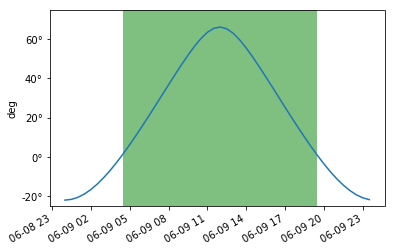

In [6]:
from astropy.coordinates import EarthLocation, AltAz
from astropy.time import Time
import numpy as np
from astropy.visualization import quantity_support

# Define coordinate
coord_crab = SkyCoord.from_name('crab')

# Set location
annecy = EarthLocation(lat=45.8058 * u.deg, lon=6.5726 * u.deg)

# Define array of times (30 minute intervals)
time_step = 30 * u.min
time_stop = 1 * u.day
time_intervals = np.arange(0, time_stop.to('min').value, time_step.value) * u.min

time_start = Time('2017-06-09 00:00:00')
times = Time(time_start + time_intervals)

# Get AltAz coordinates
altaz = AltAz(obstime=times, location=annecy)
crab_altaz = coord_crab.transform_to(altaz)

# Get altitude over horizon
altitudes = crab_altaz.alt.to('deg')

# Get times when altitude > 0
above_horizon = altitudes > 0 * u.deg

with quantity_support():
    plt.plot_date(times.plot_date, altitudes, fmt='-')
    
    # orient date labels at a slant
    plt.gcf().autofmt_xdate() 
    
    alt_min, alt_max = -25 * u.deg, 75 * u.deg
    plt.fill_between(times.plot_date,
                     alt_min, alt_max,
                     where=above_horizon,
                     facecolor='green',
                     alpha=0.5)
    plt.ylim(alt_min, alt_max)

## 3. Tables

- (*easy*) Add columns with the `RA` and `DEC` coordinates of the objects to the example table.

In [7]:
# Get example table
from astropy.table import Table
table = Table()
table['Source_Name'] = ['Crab', 'Sag A*', 'Cas A']
table['GLON'] = [184.55754381, 0, 111.74169477] * u.deg
table['GLAT'] = [-5.78427369, 0, -2.13544151] * u.deg

# Create SkyCoord object holding all 3 sky coordinates
coords = SkyCoord(table['GLON'].quantity, table['GLAT'].quantity, frame='galactic')

# Add new columns
table['RA'] = coords.icrs.ra
table['DEC'] = coords.icrs.dec

# Pretty-print the table
table.pprint()

Source_Name     GLON         GLAT          RA           DEC      
                deg          deg          deg           deg      
----------- ------------ ----------- ------------- --------------
       Crab 184.55754381 -5.78427369 83.6332083305  22.0144722262
     Sag A*          0.0         0.0 266.404988287 -28.9361777618
      Cas A 111.74169477 -2.13544151 350.866416709  58.8117777999


- (*advanced *) Load the Fermi 2FHL catalog table (`'data/fermi_2fhl.fits'`) and find the brighest source (the brightness value is stored in the `'Flux50'` column). What is the common name of the source (column `'ASSOC'`)?
Find all sources within 10 deg from the position of this source.

In [8]:
# Read table
fermi_2fhl = Table.read('data/fermi_2fhl_catalog.fits')

# Sort by brightness
fermi_2fhl.sort('Flux50')

# With -1 we get the last element
print('The brightest source in the catalog is: {} \n'.format(fermi_2fhl[-1]['ASSOC']))

# Define crab position
coord_crab = SkyCoord.from_name('Crab')

# Get SkyCoords of objects in the table
coords = SkyCoord(fermi_2fhl['GLON'], fermi_2fhl['GLAT'], frame='galactic')

# Find rows where separation < 1 deg
max_separation = 10 * u.deg
separation = coord_crab.separation(coords)

# Print result
fermi_2fhl[separation < max_separation]

The brightest source in the catalog is: Crab 



Source_Name,RAJ2000,DEJ2000,GLON,GLAT,Pos_err_68,Pos_err_95,TS,Spectral_Index,Unc_Spectral_Index,Intr_Spectral_Index_D11,Unc_Intr_Spectral_Index_D11,Intr_Spectral_Index_G12,Unc_Intr_Spectral_Index_G12,Flux50,Unc_Flux50,Energy_Flux50,Unc_Energy_Flux50,Flux50_171GeV,Unc_Flux50_171GeV [2],Sqrt_TS50_171GeV,Flux171_585GeV,Unc_Flux171_585GeV [2],Sqrt_TS171_585GeV,Flux585_2000GeV,Unc_Flux585_2000GeV [2],Sqrt_TS585_2000GeV,Npred,HEP_Energy,HEP_Prob,ROI,ASSOC,ASSOC_PROB_BAY,ASSOC_PROB_LR,CLASS,Redshift,NuPeak_obs,3FGL_Name,1FHL_Name,TeVCat_Name
,deg,deg,deg,deg,deg,deg,,,,,,,,ph / (cm2 s),ph / (cm2 s),erg / (cm2 s),erg / (cm2 s),ph / (cm2 s),ph / (cm2 s),,ph / (cm2 s),ph / (cm2 s),,ph / (cm2 s),ph / (cm2 s),,,GeV,,,,,,,,Hz,,,
str18,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,str25,float32,float32,str8,float32,float32,str18,str18,str18
2FHL J0534.1+2753,83.5254,27.8858,179.544,-2.70366,0.0491086,0.0790648,29.15,3.18,1.1,nan,nan,nan,nan,1.64e-11,8.02e-12,2.4e-12,1.44e-12,1.29749e-11,-5.38151e-12 .. 7.32622e-12,5.43737,5.17633e-16,nan .. 6.25489e-12,0.0,1.82047e-16,nan .. 5.89031e-12,0.0,4.9,135.43,0.99,17,S147,nan,0.893907,snr,0.0,nan,3FGL J0540.3+2756e,,
2FHL J0515.5+1530,78.8883,15.5032,187.622,-13.0937,0.0647209,0.104201,41.98,6.41,2.27,nan,nan,nan,nan,2.42e-11,9.73e-12,2.38e-12,9.85e-13,6.14874e-12,-2.17375e-12 .. 2.80429e-12,6.48593,4.58385e-13,nan .. 7.69366e-12,0.613025,1.019e-17,nan .. 6.79855e-12,0.0,6.8,68.77,0.99,17,NVSS J051547+152716,0.993994,nan,bll,nan,6.66807e+13,3FGL J0515.8+1526,1FHL J0515.9+1528,
2FHL J0521.7+2112,80.4385,21.209,183.607,-8.71362,0.0311897,0.0502154,562.56,2.92,0.27,2.78,0.28,2.76,0.28,2.04e-10,2.75e-11,3.29e-11,5.86e-12,1.65151e-10,-2.17974e-11 .. 2.38638e-11,23.1954,8.315e-12,-4.22348e-12 .. 6.16281e-12,5.34594,7.5567e-17,nan .. 5.98771e-12,0.0,58.9,316.79,0.86,17,TXS 0518+211,0.99999,0.986661,bll,0.108,2.16272e+14,3FGL J0521.7+2113,1FHL J0521.7+2113,TeV J0521+211
2FHL J0617.2+2234e,94.31,22.58,189.048,3.03345,0.0,0.0,398.64,2.66,0.21,nan,nan,nan,nan,2.7e-10,3.21e-11,4.97e-11,8.39e-12,2.10898e-10,-2.58071e-11 .. 2.79682e-11,18.8028,2.49341e-11,-8.29729e-12 .. 1.05299e-11,6.61884,7.13726e-12,-3.98377e-12 .. 6.37625e-12,3.69925,78.2,699.5,0.98,23,IC 443,nan,nan,snr,nan,nan,3FGL J0617.2+2234e,1FHL J0617.2+2234e,TeV J0616+225
2FHL J0534.5+2201,83.6341,22.0215,184.552,-5.77982,0.0302509,0.0487039,5149.74,2.13,0.07,nan,nan,nan,nan,1.31e-09,6.83e-11,3.52e-10,2.9e-11,9.94072e-10,-5.7595e-11 .. 5.94726e-11,63.5751,2.43875e-10,-2.82542e-11 .. 3.04354e-11,33.1807,5.27536e-11,-1.33401e-11 .. 1.60478e-11,14.4639,377.7,1463.3,1.0,19,Crab,0.998329,0.996944,pwn,nan,nan,3FGL J0534.5+2201i,1FHL J0534.5+2201,TeV J0534+220p


- (*expert*) Load the table `fermi_2fhl.fits` and make an all sky plot of the source positions.

## 4. FITS Images and WCS

- (*easy*) Read in the data from the other energy bands (`'data/casa_1.5-3.0keV.fits.gz'` and `'data/casa_4.0-6.0keV.fits.gz'`) as well, sum up all the data from the three energy bands. Plot the summed data using [plt.imshow()](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.axes.Axes.imshow.html) again.

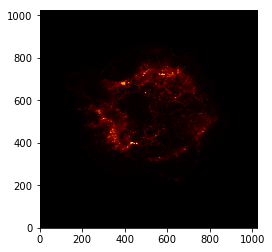

In [9]:
from astropy.io import fits

filenames = ['data/casa_0.5-1.5keV.fits.gz', 'data/casa_1.5-3.0keV.fits.gz', 'data/casa_4.0-6.0keV.fits.gz']

data_list = []

for filename in filenames:
    image_hdu = fits.open(filename)['PRIMARY']
    data_list.append(image_hdu.data)
    
data_summed = np.sum(data_list, axis=0)
plt.imshow(data_summed, origin='lower', cmap='afmhot')

In [10]:
from astropy.nddata.utils import Cutout2D
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel, pixel_to_skycoord

image_hdu = fits.open('data/casa_0.5-1.5keV.fits.gz')['PRIMARY']
wcs = WCS(image_hdu.header) 
image_data = image_hdu.data

pos_casa = SkyCoord.from_name('Cas A')

data_cutout = Cutout2D(image_data, position=pos_casa, wcs=wcs, size=0.05 * u.deg)

# Find index of maximum value (this will return the index on the flattened array)
idx_flat = data_cutout.data.argmax()

# Transform back to the original shape
idx = np.unravel_index(idx_flat, data_cutout.data.shape)

# Transform to SkyCoord
pos = pixel_to_skycoord(*idx, wcs=data_cutout.wcs)
print("The position of the brightest pixel in the image is: {}".format(pos))

The position of the brightest pixel in the image is: <SkyCoord (ICRS): (ra, dec) in deg
    ( 350.86631082,  58.81173721)>


- (*very hard*) Calculate a radial profile of the image data to estimate the size of the shell of the supernova remnant. For this sum up all the data within a set of rings (specified  by `radii_min` and `radii_max`, choose a total minimum radius of `0 arcmin` and total maximum radius of `5 arcmin`) around the center position of *Cas A*. You can use [np.indices()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.indices.html) to get arrays of x and y pixel positions. Make sure you use clever numpy broadcasting to avoid a Python loop over the `radii_min` and `radii_max` arrays (**hint**: [ndarray.reshape(-1, ...)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html#numpy.reshape) might be useful to expand the data and radius array to the third dimension).

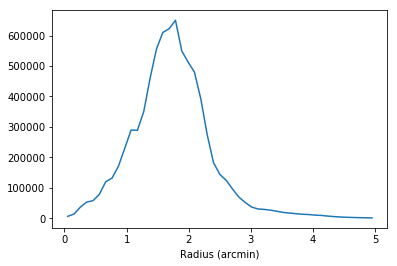

In [11]:
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel, pixel_to_skycoord
 
# open image
image_hdu = fits.open('data/casa_1.5-3.0keV.fits.gz')['PRIMARY']
wcs = WCS(image_hdu.header)
image_data = image_hdu.data

# define position and integration radius
pos_casa = SkyCoord.from_name('Cas A')

# create an array of sky positions for each pixel
pix_positions = np.indices(image_data.shape)
sky_positions = pixel_to_skycoord(*pix_positions, wcs=wcs)

# calculate separation image
separation = pos_casa.separation(sky_positions)

# initialize radius arrays
radii = np.linspace(0, 5, 50).reshape(-1, 1, 1) * u.arcmin
radii_min, radii_max = radii[:-1], radii[1:]

# mask out the annulus regions
mask = (separation > radii_min) & (separation < radii_max)

data_masked = mask * image_data.reshape(-1, 1024, 1024)
data_summed = data_masked.sum(axis=-1).sum(axis=-1)

radius_center = (radii_min[:, 0, 0] + radii_max[:, 0, 0]) / 2.

with quantity_support():
    plt.plot(radius_center, data_summed)
    plt.xlabel('Radius (arcmin)')


## 5. Plotting of sky images (optional)

- (*easy*) Make a combined plot of the Chandra data for all energy bands side by side (one row, three columns)
and put the energy information in the title of the subplot. You can use e.g. `plt.sublots()`.  

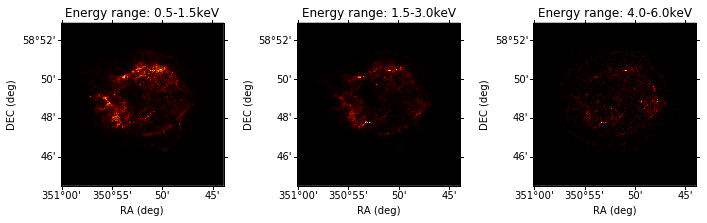

In [12]:
from astropy.io import fits
from astropy.wcs import WCS

# We define a figure size, that has an aspect ratio to accomodate three plots side by side
fig = plt.figure(figsize=(12, 3))
filenames = ['data/casa_0.5-1.5keV.fits.gz', 'data/casa_1.5-3.0keV.fits.gz', 'data/casa_4.0-6.0keV.fits.gz']

# For convenience we use a Python loop here, but the same can be achieved
# by copy and pasting the code for one energy band
for idx, filename in enumerate(filenames):
    image_hdu = fits.open(filename)['PRIMARY']
    wcs = WCS(image_hdu.header)
    ax = plt.subplot(1, 3, idx + 1, projection=wcs)
    ax.imshow(image_hdu.data, origin='lower', cmap='afmhot')
    
    # We extract the energy range from the filename, by setting it "by hand" is also fine
    energy_range = filename[10:20]
    ax.set_title('Energy range: {}'.format(energy_range))
    
    ax.set_xlabel('RA (deg)')
    ax.set_ylabel('DEC (deg)')
    

- (*advanced*) Make a combined RGB image of the Chandra data in different energy bands. Therefore you have to
renormalize the data per energy band to the maximum value of respective energy band and combine the data into a 3d array with a shape that is recognised by `plt.imshow()` (check the matplotlib documentation!).

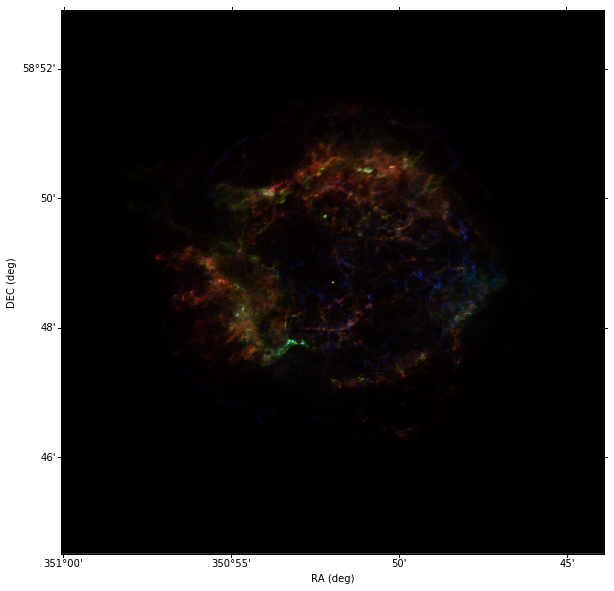

In [13]:
data_rgb = []

for filename in filenames:
    image_hdu = fits.open(filename)['PRIMARY']
    data = image_hdu.data
    data /= data.max()
    data_rgb.append(data)

data_rgb_stacked = np.stack(data_rgb, axis=2)

plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=wcs)
ax.imshow(data_rgb_stacked, origin='lower')

ax.set_xlabel('RA (deg)')
ax.set_ylabel('DEC (deg)')

## Acknowledgements
![](asterics_log.png)

This tutorial was supported by the H2020-Astronomy ESFRI and Research Infrastructure Cluster (Grant Agreement number: 653477).